In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import re
import seaborn as sns
import time
import lightgbm as lgbm
from pathlib import Path
import pickle
from catboost import CatBoostClassifier, cv, Pool
import scikitplot as skplt
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, tpe, partial

import itertools
from itertools import combinations

import scipy as sp
from scipy.stats import pearsonr, chi2_contingency

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

import datetime as dt
from dateutil import relativedelta

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
from statsmodels.stats.proportion import proportion_confint

import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

import sklearn.metrics as met
from sklearn import linear_model, preprocessing, model_selection, svm, datasets, tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.metrics import plot_confusion_matrix, auc, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, MinMaxScaler, Binarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import json
from io import StringIO

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima

from tbats import TBATS, BATS
import shap 
import xgboost as xgb

# Part 2

## We're trying to test the success of an experiment in which the Uber-esque company (Ultimate) reimburses drivers for tolls between cities Gotham and Metropolis in order to get more customers.  We should see an increase in drive distances due to greater willingness to cross the bridge.  We should also see an increase in the total number of rides due to more routes being offered.  (Ideally, we'd have location/zip code data of start/stop points of rides, but that doesn't seem offered.)

### a. We'd implement this experiment by getting at least a few weeks of data from a promo period of time in which tolls were paid by Ultimate.  Using start/end point location data, we could see the raw # of rides between the two cities.  We could also compare the sum of the distance of rides and # of rides on an hourly basis for each day of the week.  We'd expect to see more of both, and we could express the increase in raw amounts and percents.

### b. We could use the ADFuller Test to make sure that our data is properly differenced and stationary.

### c. Using profit data for each ride we could judge if the rides turned a profit given that Ultimate is having to bear the cost of the toll.  The increase in total miles driven and number of rides could possibly paint a picture of overall increase in the use of their service.  This could possibly be useful in determining whether even a loss in proft might be acceptable if it provides a large enough boon in customer satisfaction and favorability over a similar company.

# Now the users data

In [2]:
with open('ultimate_data_challenge.json') as f:
  data = json.load(f)
users = pd.DataFrame(data)

In [3]:
users.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,50000,3,Winterfell,23336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trips_in_first_30_days,50000,NaN,NaN,NaN,2.2782,3.79268,0,0,1,3,125
signup_date,50000,31,2014-01-18,2948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,41878,NaN,NaN,NaN,4.60156,0.617338,1,4.3,4.9,5,5
avg_surge,50000,NaN,NaN,NaN,1.07476,0.222336,1,1,1,1.05,8
last_trip_date,50000,182,2014-06-29,2036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone,49604,2,iPhone,34582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surge_pct,50000,NaN,NaN,NaN,8.84954,19.9588,0,0,0,8.6,100
ultimate_black_user,50000,2,False,31146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,50000,NaN,NaN,NaN,60.9261,37.0815,0,33.3,66.7,100,100


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [6]:
users.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [7]:
(100*users[users.columns[users.isnull().any()]].isnull().sum()/len(users.index)).sort_values()

avg_rating_by_driver     0.402
phone                    0.792
avg_rating_of_driver    16.244
dtype: float64

### There's really no way for us to infer the phone type, so we'll drop thos NaNs.

In [8]:
users.dropna(subset=['phone'], inplace=True)

In [9]:
users['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

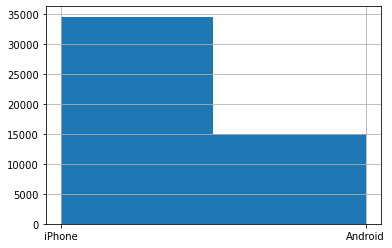

In [10]:
users['phone'].hist(bins=2)

### Since it's possible to not rate users, we'll fill those NaNs with 0.

In [11]:
users['avg_rating_of_driver'].fillna(value=0, inplace=True)
users['avg_rating_by_driver'].fillna(value=0, inplace=True)     

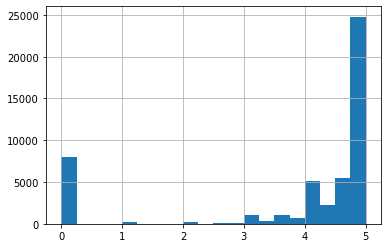

In [12]:
users['avg_rating_of_driver'].hist(bins=20)

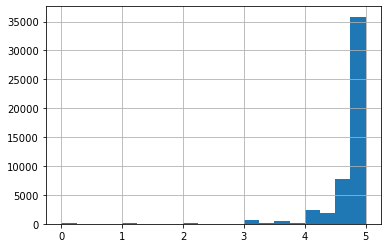

In [13]:
users['avg_rating_by_driver'].hist(bins=20)

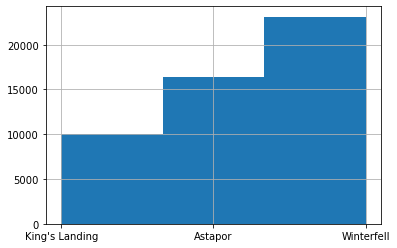

In [14]:
users['city'].hist(bins=3)

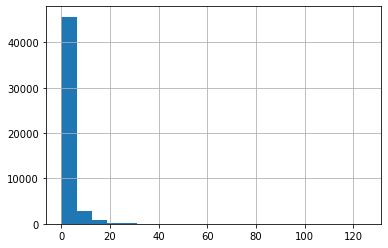

In [15]:
users['trips_in_first_30_days'].hist(bins=20)

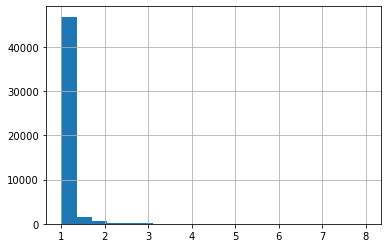

In [16]:
users['avg_surge'].hist(bins=20)

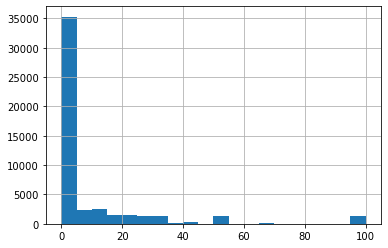

In [17]:
users['surge_pct'].hist(bins=20)

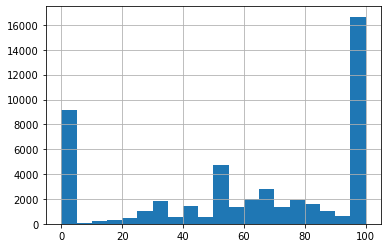

In [18]:
users['weekday_pct'].hist(bins=20)

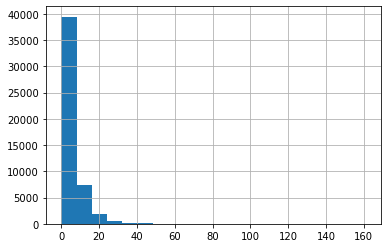

In [19]:
users['avg_dist'].hist(bins=20)

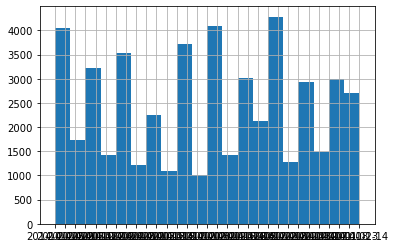

In [20]:
users['signup_date'].hist(bins=20)

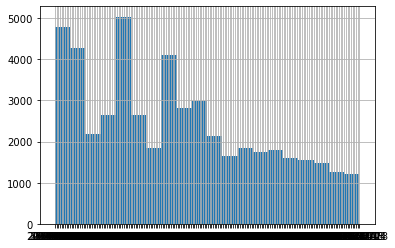

In [21]:
users['last_trip_date'].hist(bins=20)

In [22]:
users['last_trip_date'].max()

'2014-07-01'

In [23]:
users['last_trip_date']=pd.to_datetime(users['last_trip_date'])
users['signup_date']=pd.to_datetime(users['signup_date'])

## 36.65% of users who signed up in Jan are retained as of July 01.

In [24]:
(users['last_trip_date']>'2014-06-01').sum()/len(users)

0.3665027013950488

## Modeling

In [25]:
users['retained'] = 0
for x in range(len(users)):
    if users['last_trip_date'].iloc[x]>pd.to_datetime('2014-06-01'):
        users['retained'].iloc[x] = 1

In [26]:
users['ultimate_black_user']=users['ultimate_black_user'].astype('int32')

In [27]:
dummies = pd.get_dummies(data=users, columns=['city','phone'], prefix=['city','OS'], dtype=int)

In [28]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  49604 non-null  int64         
 1   signup_date             49604 non-null  datetime64[ns]
 2   avg_rating_of_driver    49604 non-null  float64       
 3   avg_surge               49604 non-null  float64       
 4   last_trip_date          49604 non-null  datetime64[ns]
 5   surge_pct               49604 non-null  float64       
 6   ultimate_black_user     49604 non-null  int32         
 7   weekday_pct             49604 non-null  float64       
 8   avg_dist                49604 non-null  float64       
 9   avg_rating_by_driver    49604 non-null  float64       
 10  retained                49604 non-null  int64         
 11  city_Astapor            49604 non-null  int32         
 12  city_King's Landing     49604 non-null  int32 

In [29]:
X = dummies.drop(['last_trip_date','retained','signup_date'], axis=1)
y = dummies['retained'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
# build scaler based on training data and apply it to test data to then also scale the test data
# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [30]:
categorical_features = ['OS_Android','OS_iPhone','city_Winterfell',"city_King's Landing",'city_Astapor','ultimate_black_user']

## Testing different LightGBM models using Bayesian Boosting
gbdt: traditional Gradient Boosting Decision Tree

rf: Random Forest

dart: Dropouts meet Multiple Additive Regression Trees

goss: Gradient-based One-Side Sampling

In [31]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'gbdt',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO0 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (1, 1000),
                                        "lambda_l2" : (.001,.9),
                                        "lambda_l1" : (.001,.9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9)
                                         })

# logger = JSONLogger(path="./log0.json")
# lgbBO0.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO0.maximize(init_points=5, n_iter=10)

In [32]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate, bagging_fraction):
    params = {
        "objective" : "binary",
        'boosting': 'rf',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100,
        'bagging_freq': 1,
        'bagging_fraction': bagging_fraction
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO141 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (2, 1000),
                                        "lambda_l2" : (.001, .9),
                                        "lambda_l1" : (.001, .9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9),
#                                         'feature_fraction': (.1,.9),
                                        'bagging_fraction': (.001,.9)
                                         })

# logger = JSONLogger(path="./log1.json")
# lgbBO1.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO141.maximize(init_points=5, n_iter=10)

In [33]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'dart',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO7427 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (1, 1000),
                                        "lambda_l2" : (.001, .9),
                                        "lambda_l1" : (.001, .9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9)
#                                         'feature_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log2.json")
# lgbBO2.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO7427.maximize(init_points=5, n_iter=10)

In [34]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'goss',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO987 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (1, 1000),
                                        "lambda_l2" : (.001, .9),
                                        "lambda_l1" : (.001, .9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9)
#                                         'feature_fraction': (.1,1)
                                         })

# logger = JSONLogger(path="./log3.json")
# lgbBO3.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO987.maximize(init_points=5, n_iter=10)

## GBDT performed the best out of these models.

In [ ]:
def lgb_eval(num_leaves, lambda_l2, lambda_l1, max_depth, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "binary",
        'boosting': 'gbdt',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : learning_rate,
        'feature_fraction': 1,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 100,
        'early_stopping_rounds': 100
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    cv_result = lgbm.cv(params,
                       lgtrain,
                       stratified=True,
                       nfold=2)
    return cv_result['auc-mean'][-1]

lgbBO4325 = BayesianOptimization(lgb_eval, {
                                        "num_leaves" : (1, 1000),
                                        "lambda_l2" : (.001,.9),
                                        "lambda_l1" : (.001,.9),
                                        'max_depth': (1,1000),
                                        'min_data_in_leaf': (1, 1000), 
                                        "learning_rate" : (.001,.9)
                                         })

# logger = JSONLogger(path="./log0.json")
# lgbBO0.subscribe(Events.OPTIMIZATION_STEP, logger)

lgbBO4325.maximize(init_points=50, n_iter=100)

In [35]:
lgbBO4325.max

In [36]:
params = {
        "objective" : "binary",
        'boosting': 'gbdt',
        "metric" : "auc", 
        'is_unbalance': True,
        "num_threads" : 6,
        'feature_fraction': 1,
        'lambda_l1': .8044162061107845,
        'lambda_l2': 0.30322125560150015,
        'learning_rate': 0.199459453303991,
        'max_depth': 978,
        'min_data_in_leaf': 644,
        'num_leaves': 795,
        "verbosity" : -1,
        'histogram_pool_size': 50000,
        'num_boost_round': 1000,
        'early_stopping_rounds': 100
}
    
lgtrain = lgbm.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgtest = lgbm.Dataset(X_test, y_test, categorical_feature=categorical_features)
lgclf = lgbm.train(
        params, 
        lgtrain,
        valid_sets=[lgtrain, lgtest],
        valid_names=["train", "test"],
        verbose_eval=100
)

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.887591	test's auc: 0.863111
Early stopping, best iteration is:
[82]	train's auc: 0.884448	test's auc: 0.863386


# There aren't any strong correlations

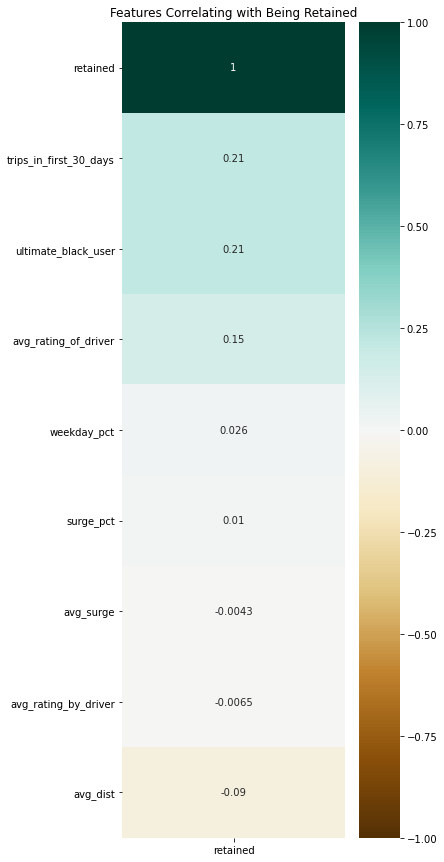

In [42]:
plt.figure(figsize=(5, 15))
heatmap = sns.heatmap(users.corr()[['retained']].sort_values(by='retained', ascending=False).head(10), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Being Retained')
plt.savefig('retained_corr.png', bbox_inches = "tight")

# But SHAP shows that some variables have a strong effect on the outcome.  Here are a few samples of predicted results.

In [66]:
explainer = shap.TreeExplainer(lgclf)
shap_values = explainer.shap_values(X)

In [68]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:])

In [74]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X.iloc[1,:])

In [75]:
shap.force_plot(explainer.expected_value[1], shap_values[1][2,:], X.iloc[2,:])

# Here're the first 1000 results and the most predictive variables.

In [70]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X.iloc[:1000,:])

# And here're the variables that have the greatest effect on the predictions.

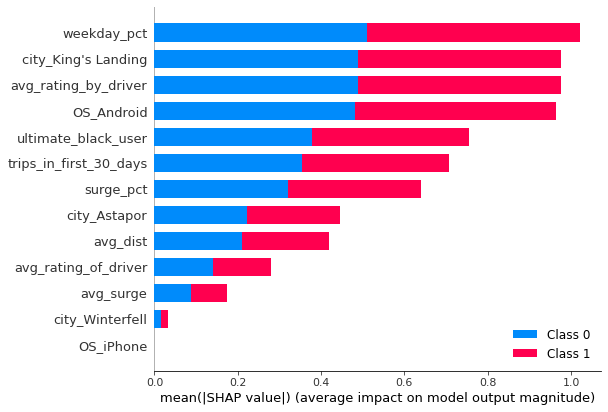

In [71]:
shap.summary_plot(shap_values, X)

# Looking at the correlations, there're a few takeaways.  

### Riders who used the app for only weekdays/weekends had lower retention rates.  This requires some more research to draw any insights from.

### Riders from King's Landing had high retention rates, while low from Astapor.  Perhaps we could find what is driving this difference.

### Avg rating of the rider by the driver had a strong effect on rider retention, until it reached 5 and had a sudden drop off.  Nicer/friendlier riders get better ratings, in general.  But why the drop at 5?

### Android users had a low retention rate.  This could be a problem in how user-friendly the app is.  This is the most immediately actionable fix to address.

### Ultimate Black users had a high retention rate.  Perhaps some of these features could be rolled into the normal user experience or we could promote Ultimate Black sign-up more?

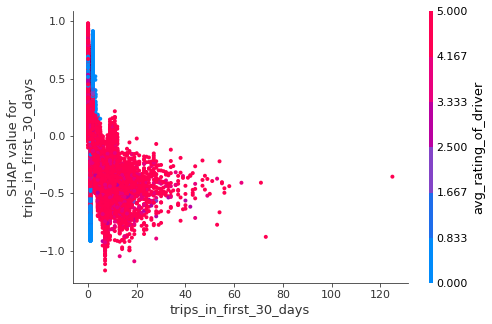

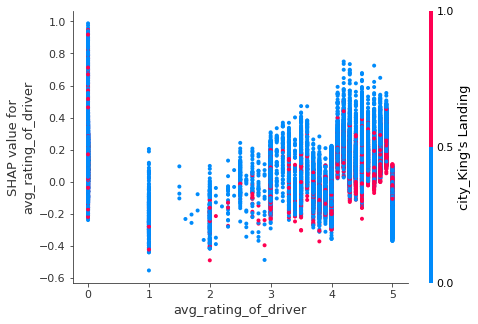

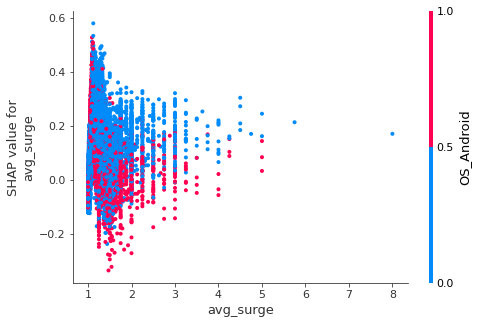

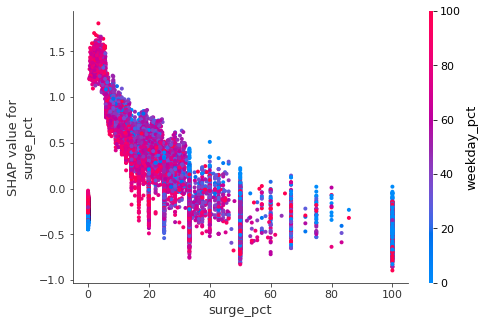

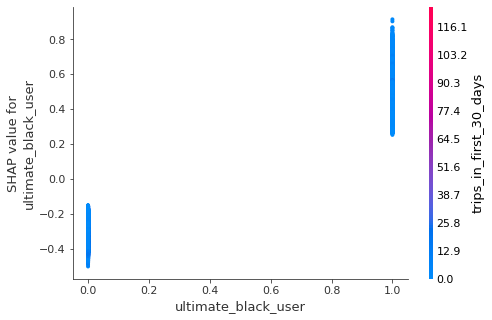

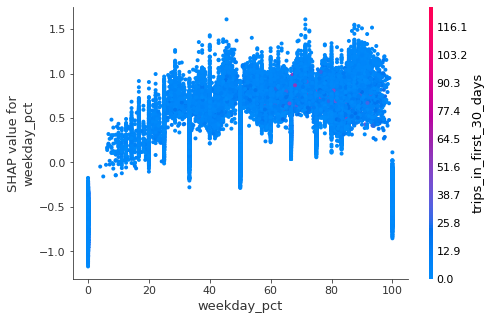

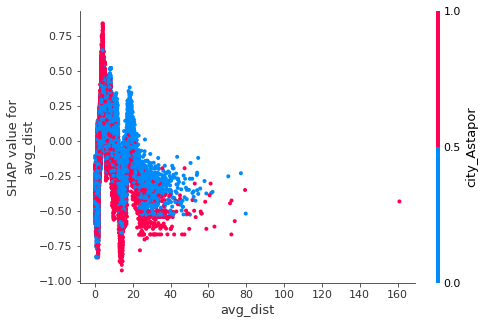

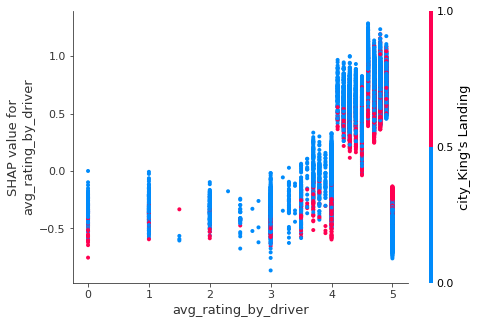

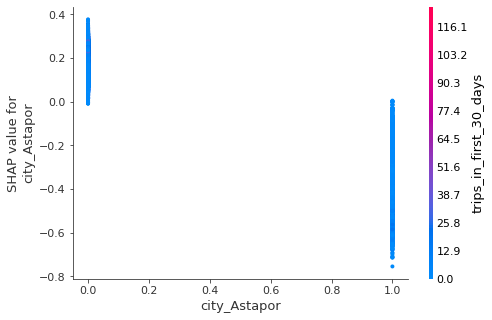

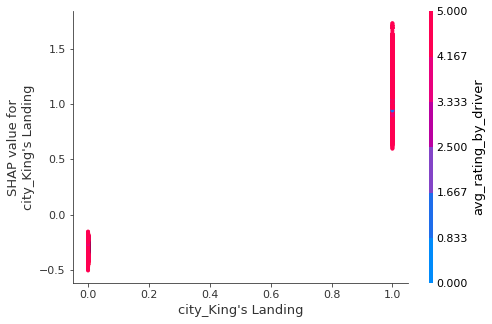

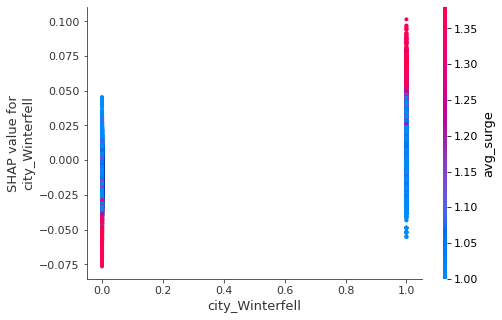

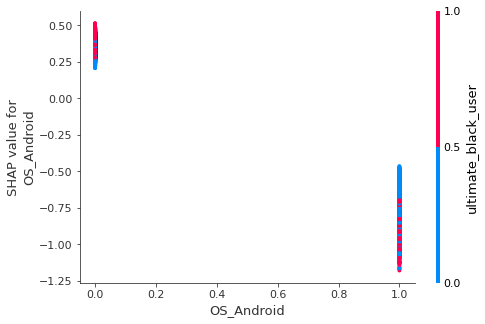

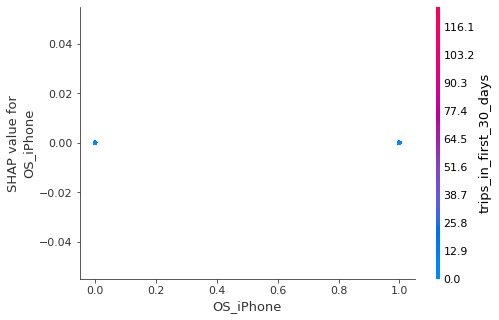

In [76]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X)